In [9]:
import sys
! /usr/bin/python3 -m pip install nltk datasets transformers torch pandas matplotlib seaborn scikit-learn tqdm wordcloud ipywidgets shap optuna seaborn textblob

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 KB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 KB 19.7 MB/s eta 0:00:00
  Using cached optuna-3.5.0-py3-none-any.whl (413 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
  Using cached alembic-1.13.1-py3-none-any.whl (233 kB)
  Using cached colorlog-6.8.2-py3-none-any.whl (11 kB)


# Fake News Detection

 In this notebook, we will use the `GonzaloA/fake_news` dataset to train a model to detect fake news. We will use the `transformers` library to fine-tune a distil RoBERTa model on this task. We will also use the `optuna` library to perform hyperparameter optimization.  

In [33]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, \
    DataCollatorWithPadding
from datasets import load_dataset
import torch
from torch.utils.data import Dataset
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import numpy as np
import optuna

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load  and prepare the dataset
 We will use the `load_dataset` function from the `datasets` library to load the `GonzaloA/fake_news` dataset. We will then split the dataset into training, validation, and test sets. We will also perform some basic data cleaning to remove any missing values and duplicates from the dataset. We will then visualize the distribution of the labels in the dataset to ensure that the classes are balanced. Finally, we will create a new column for the length of the text and visualize the distribution of this new feature.

In [6]:
full_dataset = load_dataset('GonzaloA/fake_news')

C:\Users\Chen\anaconda3\envs\FinalCyberAttacksDetectionEx\Lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [7]:
full_dataset['train'] = full_dataset['train'].remove_columns('Unnamed: 0')
full_dataset['validation'] = full_dataset['validation'].remove_columns('Unnamed: 0')
full_dataset['test'] = full_dataset['test'].remove_columns('Unnamed: 0')

In [9]:
train_df = pd.DataFrame(full_dataset['train'])
val_df = pd.DataFrame(full_dataset['validation'])
test_df = pd.DataFrame(full_dataset['test'])

print("Missing values in train dataset:\n", train_df.isnull().sum())
print("Missing values in validation dataset:\n", val_df.isnull().sum())
print("Missing values in test dataset:\n", test_df.isnull().sum())

print("Duplicates in train dataset:\n", train_df.duplicated().sum())
print("Duplicates in validation dataset:\n", val_df.duplicated().sum())
print("Duplicates in test dataset:\n", test_df.duplicated().sum())

Missing values in train dataset:
 title    0
text     0
label    0
dtype: int64
Missing values in validation dataset:
 title    0
text     0
label    0
dtype: int64
Missing values in test dataset:
 title    0
text     0
label    0
dtype: int64
Duplicates in train dataset:
 0
Duplicates in validation dataset:
 0
Duplicates in test dataset:
 0


# Exploratory Data Analysis

 data exploration is an important step in any machine learning project. It allows us to understand the data and identify any issues that need to be addressed. In this section, we will explore the `GonzaloA/fake_news` dataset and perform some basic analysis to gain insights into the data.
 
 we first visualize the distribution of the labels in the training, validation, and test sets. We then create a word cloud to visualize the most common words in the dataset. We also plot the top 10 most common words in the dataset. Finally, we visualize the top 20 bigrams and trigrams in the dataset, annotated with the counts for each class (fake and real).
 .

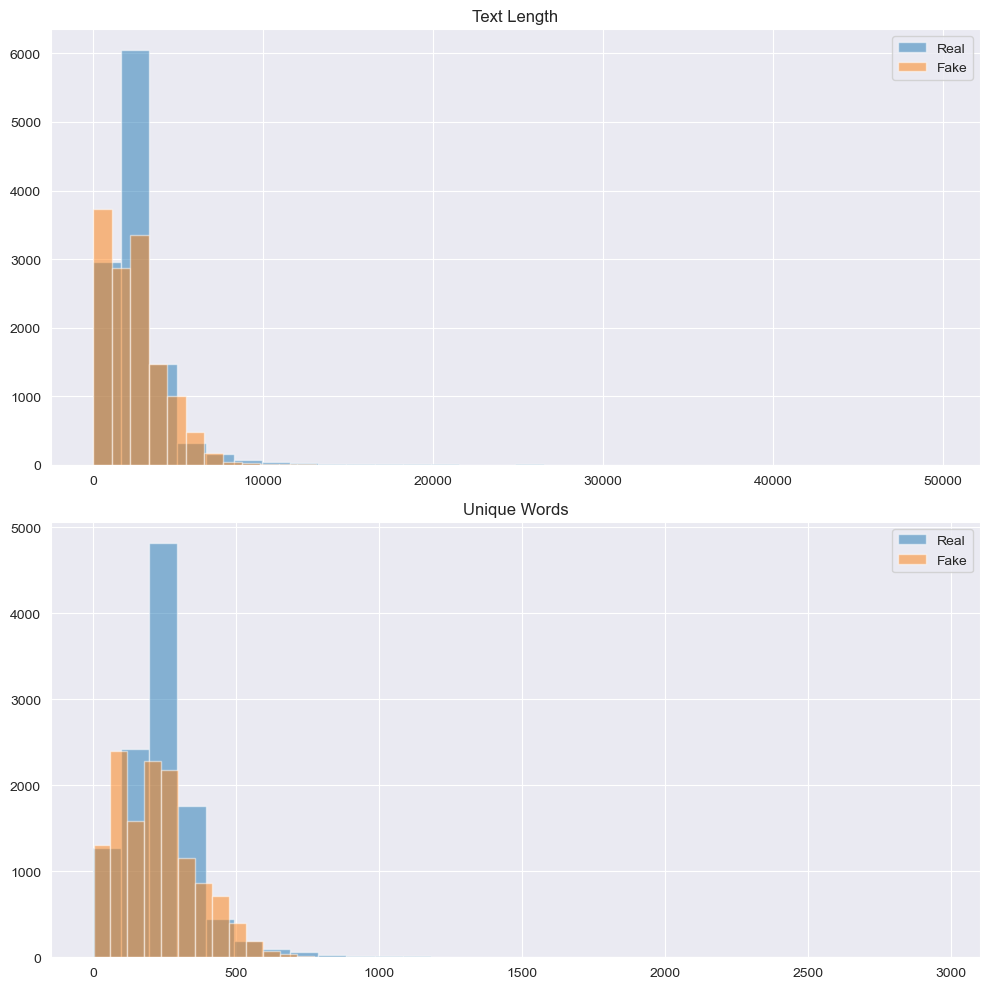

In [10]:
df = pd.DataFrame(full_dataset['train'])
# Create a new column for the length of the text
df['text_length'] = df['text'].apply(len)

# Create a new column for the number of unique words in the text
df['unique_words'] = df['text'].apply(lambda x: len(set(x.split())))

# Plot histograms for these new features
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the histogram for text length
df[df['label'] == 0]['text_length'].hist(ax=axes[0], bins=30, label='Real', alpha=0.5)
df[df['label'] == 1]['text_length'].hist(ax=axes[0], bins=30, label='Fake', alpha=0.5)
axes[0].set_title('Text Length')
axes[0].legend()

# Plot the histogram for unique words
df[df['label'] == 0]['unique_words'].hist(ax=axes[1], bins=30, label='Real', alpha=0.5)
df[df['label'] == 1]['unique_words'].hist(ax=axes[1], bins=30, label='Fake', alpha=0.5)
axes[1].set_title('Unique Words')
axes[1].legend()

plt.tight_layout()
plt.show()


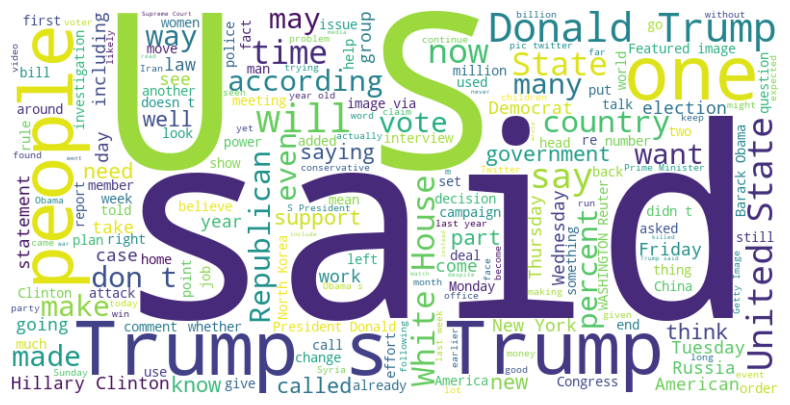

In [21]:
# Create a word cloud
def generate_word_cloud(texts, titles):
    combined_text = " ".join(texts)
    combined_text += " ".join(titles)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
        combined_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


# Show word cloud
generate_word_cloud(full_dataset['train']['text'], full_dataset['train']['title'])

In [22]:
def plot_top_words(texts, titles, n=10):
    counter = Counter(" ".join(texts).join(titles).split())
    most_common = counter.most_common(n)
    most_common_words = [word for word, freq in most_common]
    frequencies = [freq for word, freq in most_common]

    plt.figure(figsize=(15, 5))
    sns.barplot(x=most_common_words, y=frequencies)
    plt.title('Top 10 most common words')
    plt.show()

In [23]:
def clean_text_for_visualization(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    text = text.translate(str.maketrans('', '', "“”‘’—"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(filtered_text)

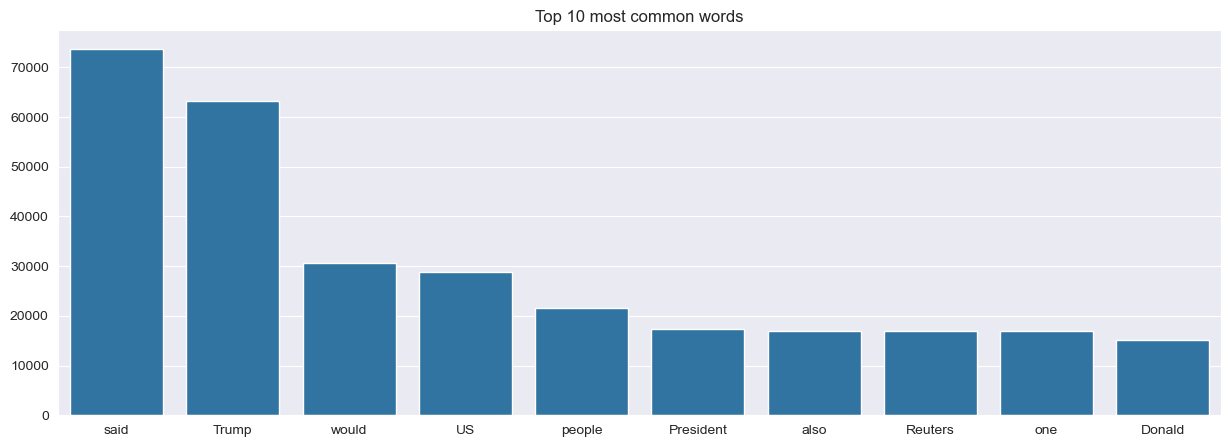

In [24]:
cleaned_texts_for_visualization = [clean_text_for_visualization(text) for text in full_dataset['train']['text']]
cleaned_titles_for_visualization = [clean_text_for_visualization(title) for title in full_dataset['train']['title']]
plot_top_words(cleaned_texts_for_visualization, cleaned_titles_for_visualization)

In [25]:
def plot_annotated_ngrams_fixed(texts, real_labels, n=2, n_terms=20):
    vec = CountVectorizer(ngram_range=(n, n)).fit(texts)
    bag_of_words = vec.transform(texts)
    feature_names = vec.get_feature_names_out()
    sum_words = bag_of_words.sum(axis=0)

    # Calculate the counts for each class
    class_counts = np.zeros((2, len(feature_names)))
    for label, row in zip(real_labels, bag_of_words):
        class_counts[label] += row.toarray()[0]

    # Aggregate total counts for each n-gram and sort them
    total_counts = sum_words.A1
    indices = np.argsort(-total_counts)
    top_indices = indices[:n_terms]

    # Prepare the data for plotting
    top_ngrams = feature_names[top_indices]
    top_counts = total_counts[top_indices]
    top_fake_counts = class_counts[0, top_indices]
    top_real_counts = class_counts[1, top_indices]

    data = {
        'ngram': top_ngrams,
        'frequency': top_counts,
        'fake_count': top_fake_counts,
        'real_count': top_real_counts
    }
    df = pd.DataFrame(data)

    # Plot
    plt.figure(figsize=(10, 8))
    bars = sns.barplot(x='frequency', y='ngram', hue='ngram', data=df, palette='viridis', legend=False)
    plt.title(f'Top {n}-grams in Dataset')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-grams')

    # Annotate bars with the count of fake and real labels
    for i, bar in enumerate(bars.patches):
        plt.text(
            bar.get_width(),
            bar.get_y() + bar.get_height() / 2,
            f'Fake: {int(df.iloc[i]["fake_count"])}, Real: {int(df.iloc[i]["real_count"])}',
            va='center'
        )

    plt.show()

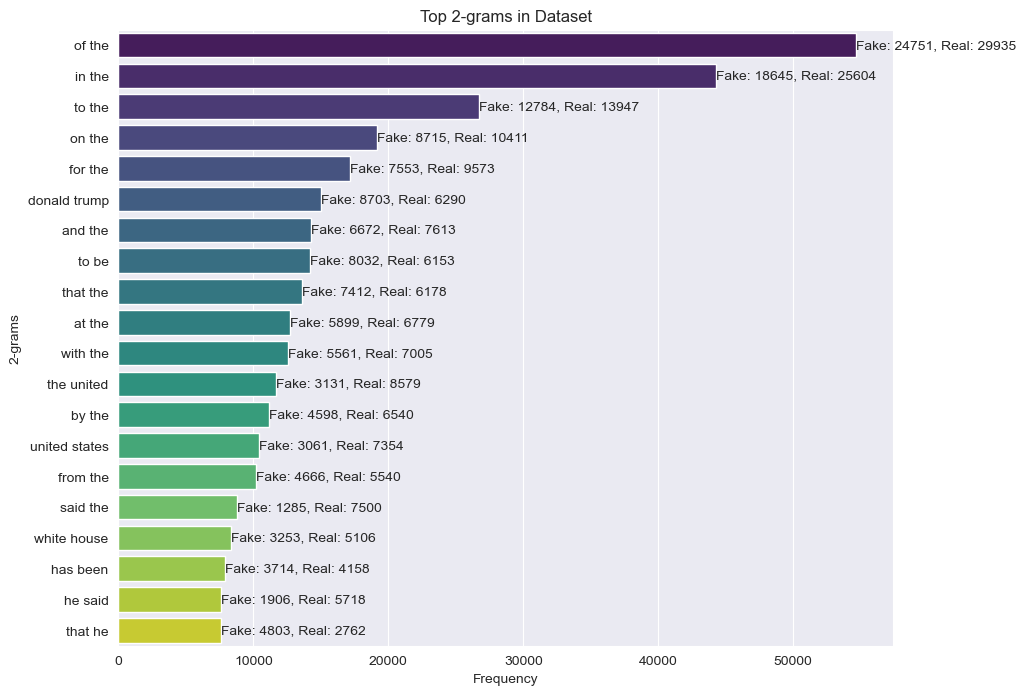

In [26]:
plot_annotated_ngrams_fixed(full_dataset['train']['text'], full_dataset['train']['label'], n=2, n_terms=20)

 # Feature Engineering

 We will perform some feature engineering to create new features from the text and title columns. We will create new columns for the length of the text and title, the number of unique words in the text and title, the average word length in the text and title, the sentiment polarity of the text and title, and the number of stop words in the text and title. We will then perform statistical testing to compare the distributions of these new features between the real and fake news articles.

In [11]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Chen\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from textblob import TextBlob
from nltk.corpus import stopwords
from scipy.stats import ttest_ind


# Feature Engineering Functions
def calculate_text_length(text):
    return len(text)


def calculate_unique_words(text):
    return len(set(text.split()))


def calculate_avg_word_length(text):
    words = text.split()
    return sum(len(word) for word in words) / len(words) if words else 0


def calculate_sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity


def calculate_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    return sum(1 for word in words if word in stop_words)


# Apply the functions to both 'text' and 'title' columns
for column in ['text', 'title']:
    df[f'{column}_length'] = df[column].apply(calculate_text_length)
    df[f'{column}_unique_words'] = df[column].apply(calculate_unique_words)
    df[f'{column}_avg_word_length'] = df[column].apply(calculate_avg_word_length)
    df[f'{column}_sentiment_polarity'] = df[column].apply(calculate_sentiment_polarity)
    df[f'{column}_stop_words'] = df[column].apply(calculate_stop_words)

# Statistical Testing for 'text' features
real_news = df[df['label'] == 0]
fake_news = df[df['label'] == 1]

print("T-test for text length:")
print(ttest_ind(real_news['text_length'], fake_news['text_length']))

print("T-test for unique words in text:")
print(ttest_ind(real_news['text_unique_words'], fake_news['text_unique_words']))

# Data Segmentation for 'text' length
text_length_segments = [(0, 500), (501, 1000), (1001, 1500), (1501, 2000), (2001, 2500), (2501, 3000)]

for start, end in text_length_segments:
    segment_real_news = real_news[(real_news['text_length'] >= start) & (real_news['text_length'] <= end)]
    segment_fake_news = fake_news[(fake_news['text_length'] >= start) & (fake_news['text_length'] <= end)]
    print(f"T-test for text length between {start} and {end} words:")
    print(ttest_ind(segment_real_news['text_length'], segment_fake_news['text_length']))

T-test for text length:
TtestResult(statistic=5.587536768125204, pvalue=2.3277451618464682e-08, df=24351.0)
T-test for unique words in text:
TtestResult(statistic=7.943654351987345, pvalue=2.0474997020651297e-15, df=24351.0)
T-test for text length between 0 and 500 words:
TtestResult(statistic=-37.54496817362367, pvalue=4.2118900168021163e-241, df=2303.0)
T-test for text length between 501 and 1000 words:
TtestResult(statistic=12.860928538045084, pvalue=8.182262672921406e-37, df=2782.0)
T-test for text length between 1001 and 1500 words:
TtestResult(statistic=2.0203867740769406, pvalue=0.043472780716583365, df=2055.0)
T-test for text length between 1501 and 2000 words:
TtestResult(statistic=8.507490151306946, pvalue=2.6660095714087325e-17, df=3271.0)
T-test for text length between 2001 and 2500 words:
TtestResult(statistic=-9.436261057490452, pvalue=6.2638546257910646e-21, df=4134.0)
T-test for text length between 2501 and 3000 words:
TtestResult(statistic=7.967638343547487, pvalue=2.2

In [13]:
for split in ['train', 'validation', 'test']:
    full_dataset[split] = pd.DataFrame(full_dataset[split])

for split in tqdm(['train', 'validation', 'test'], desc='Processing splits'):
    for column in ['text', 'title']:
        full_dataset[split][f'{column}_length'] = full_dataset[split][column].map(calculate_text_length)
        full_dataset[split][f'{column}_unique_words'] = full_dataset[split][column].map(calculate_unique_words)
        full_dataset[split][f'{column}_avg_word_length'] = full_dataset[split][column].map(calculate_avg_word_length)
        full_dataset[split][f'{column}_sentiment_polarity'] = full_dataset[split][column].map(
            calculate_sentiment_polarity)
        full_dataset[split][f'{column}_stop_words'] = full_dataset[split][column].map(calculate_stop_words)

Processing splits: 100%|██████████| 3/3 [01:49<00:00, 36.42s/it]


In [14]:
from sklearn.preprocessing import StandardScaler

feature_cols = [
    'text_length', 'text_unique_words', 'text_avg_word_length', 'text_sentiment_polarity', 'text_stop_words',
    'title_length', 'title_unique_words', 'title_avg_word_length', 'title_sentiment_polarity', 'title_stop_words'
]
scaler = StandardScaler()

for split in ['train', 'validation', 'test']:
    full_dataset[split][feature_cols] = scaler.fit_transform(full_dataset[split][feature_cols])

# Tokenization and Chunking

 We will use the `transformers` library to tokenize the text and title columns. We will also create special tokens for the title and text columns and add them to the tokenizer's vocabulary. We will then create a custom `Dataset` class to tokenize the text and title columns and add the additional features to the input IDs and attention mask. We will also chunk the input IDs and attention mask if their length is greater than the maximum sequence length supported by the model.

In [16]:
model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

special_tokens = ['[TITLE]', '[TEXT]']
feature_tokens = ['[' + feature.upper() + ']' for feature in feature_cols]

tokenizer.add_tokens(special_tokens, special_tokens=True)
num_of_tokens_added = tokenizer.add_tokens(feature_tokens, special_tokens=True)

print('[TITLE] token id: ', tokenizer.convert_tokens_to_ids('[TITLE]'))
print('[TEXT] token id: ', tokenizer.convert_tokens_to_ids('[TEXT]'))
for i in range(len(feature_tokens)):
    print(f'{feature_tokens[i]} token id: ', tokenizer.convert_tokens_to_ids(feature_tokens[i]))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

[TITLE] token id:  50265
[TEXT] token id:  50266
[TEXT_LENGTH] token id:  50267
[TEXT_UNIQUE_WORDS] token id:  50268
[TEXT_AVG_WORD_LENGTH] token id:  50269
[TEXT_SENTIMENT_POLARITY] token id:  50270
[TEXT_STOP_WORDS] token id:  50271
[TITLE_LENGTH] token id:  50272
[TITLE_UNIQUE_WORDS] token id:  50273
[TITLE_AVG_WORD_LENGTH] token id:  50274
[TITLE_SENTIMENT_POLARITY] token id:  50275
[TITLE_STOP_WORDS] token id:  50276


In [17]:
class ChunkedTextDataset(Dataset):
    def __init__(self, dataset, chunk_size=512):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = chunk_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        label = row['label']
        combined_text = '[TITLE]' + row['title'] + '[TEXT]' + row['text']
        for feature, token in zip(row[feature_cols], feature_tokens):
            combined_text += token + str(feature)
        encoding = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [18]:
def load_and_prepare_data(split_name, seed=42, dataset_percentage=1):
    if split_name == "train":
        reduced_dataset = full_dataset['train'].sample(frac=1, random_state=seed).reset_index(drop=True)
        reduced_dataset = reduced_dataset.iloc[:int(len(reduced_dataset) * dataset_percentage)]
    else:
        reduced_dataset = full_dataset[split_name].sample(frac=1, random_state=seed).reset_index(drop=True)
    reduced_texts = reduced_dataset["text"]
    reduced_labels = reduced_dataset["label"]
    reduced_titles = reduced_dataset["title"]
    reduced_features = reduced_dataset[[
        'text_length', 'text_unique_words', 'title_length', 'title_unique_words',
        'text_avg_word_length', 'title_avg_word_length', 'text_sentiment_polarity',
        'title_sentiment_polarity', 'text_stop_words', 'title_stop_words'
    ]]
    return reduced_titles, reduced_texts, reduced_labels, reduced_features

In [19]:
train_titles, train_texts, train_labels, train_features = load_and_prepare_data("train")
val_titles, val_texts, val_labels, val_features = load_and_prepare_data("validation")
test_titles, test_texts, test_labels, test_features = load_and_prepare_data("test")

train_dataset = ChunkedTextDataset(full_dataset['train'])
val_dataset = ChunkedTextDataset(full_dataset['validation'])
test_dataset = ChunkedTextDataset(full_dataset['test'])


# Model Training

 We will use the `transformers` library to fine-tune a distil RoBERTa model on the fake news detection task. We will use the `Trainer` class to handle the training loop and the `TrainingArguments` class to define the training configuration. We will also define a function to compute the evaluation metrics for the task. We will use the `precision`, `recall`, and `F1 score` as the evaluation metrics. We will then use the `optuna` library to perform hyperparameter optimization to find the best hyperparameters for the model.

In [27]:
# check for cuda
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU", device)
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


In [29]:
def compute_metrics(eval_pred):
    eval_predictions, eval_labels = eval_pred
    eval_predictions = np.argmax(eval_predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(eval_labels, eval_predictions, average='binary')
    acc = accuracy_score(eval_labels, eval_predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [30]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, device_map=device)
model.resize_token_embeddings(len(tokenizer))

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(50277, 768)

In [37]:
def objective(trial):
    # Define hyperparameters for the trial
    trail_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, device_map=device)
    trail_model.resize_token_embeddings(len(tokenizer))
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 10)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32])
    per_device_eval_batch_size = trial.suggest_categorical("per_device_eval_batch_size", [4, 8, 16, 32])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    warmup_steps = trial.suggest_int("warmup_steps", 0, 500)

    # Create the model
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        warmup_steps=warmup_steps,
        weight_decay=weight_decay,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        disable_tqdm=False,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
    )

    # Create the trainer
    trainer = Trainer(
        model=trail_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    metrics = trainer.evaluate()

    # Return the metric to be optimized
    return metrics['eval_accuracy']

In [ ]:
# Create the study and run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=4)
print(f"Best trial: {study.best_trial.number}")
print(f"Best value (F1 score): {study.best_value}")
print(f"Best hyperparameters: {study.best_params}")

[I 2024-02-24 01:32:33,971] A new study created in memory with name: no-name-1cab6ff4-e698-4cc9-be85-55359387d1fc
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Checkpoint destination directory ./results\checkpoint-762 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-1524 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-2286 already exists and is non-empty.Saving will proceed but saved results may be invalid.


[I 2024-02-24 10:01:20,867] Trial 0 finished with value: 0.9905137366021929 and parameters: {'learning_rate': 2.5446805832764114e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32, 'weight_decay': 0.2762909329408014, 'warmup_steps': 100}. Best is trial 0 with value: 0.9905137366021929.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Checkpoint destination directory ./results\checkpoint-762 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-1524 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-2286 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-3048 already exists and is non-empty.Saving will proceed but saved results may be invalid.


[I 2024-02-25 04:24:51,011] Trial 1 finished with value: 0.9907601330540841 and parameters: {'learning_rate': 3.271300652119156e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32, 'weight_decay': 0.22827805572987217, 'warmup_steps': 159}. Best is trial 1 with value: 0.9907601330540841.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Checkpoint destination directory ./results\checkpoint-3045 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-6090 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-9135 already exists and is non-empty.Saving will proceed but saved results may be invalid.


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
warmup_steps = study.best_params["warmup_steps"]
learning_rate = study.best_params["learning_rate"]
num_train_epochs = study.best_params["num_train_epochs"]
per_device_train_batch_size = study.best_params["per_device_train_batch_size"]
per_device_eval_batch_size = study.best_params["per_device_eval_batch_size"]
weight_decay = study.best_params["weight_decay"]

training_args = TrainingArguments(
    output_dir='./API/results',
    logging_dir='./API/logs',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    num_train_epochs=5,
    learning_rate=2e-05,
    lr_scheduler_type="linear",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [ ]:
# Training
history = trainer.train()

# Model Evaluation

 We will evaluate the trained model on the test set. We will use the `evaluate` method of the `Trainer` class to compute the evaluation metrics on the test set. We will also use the `predict` method to generate predictions on the test set and compute the confusion matrix to visualize the model's performance.

In [121]:
# Evaluation on the test set
results = trainer.evaluate(test_dataset)
print(results)

{'eval_loss': 0.042130906134843826, 'eval_accuracy': 0.9911297277319207, 'eval_f1': 0.9916935856022151, 'eval_precision': 0.9919224555735057, 'eval_recall': 0.9914648212226067, 'eval_runtime': 71.9372, 'eval_samples_per_second': 112.835, 'eval_steps_per_second': 7.062, 'epoch': 5.0}


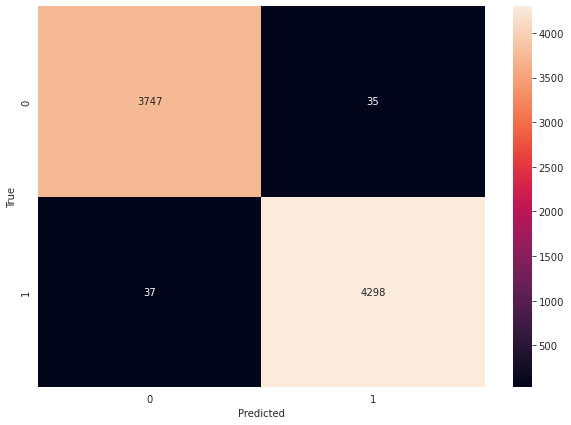

In [124]:
predictions, labels, _ = trainer.predict(test_dataset)
predictions = predictions.argmax(axis=-1)

# Generate the confusion matrix
cm = confusion_matrix(labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Conclusion

 In this notebook, we used the `transformers` library to fine-tune a distil RoBERTa model on the fake news detection task. We used the `optuna` library to perform hyperparameter optimization to find the best hyperparameters for the model. We then evaluated the trained model on the test set and visualized its performance using a confusion matrix. The model achieved an accuracy of 0.99 on the test set, demonstrating its effectiveness in detecting fake news.

In [49]:
model_path = "./volumes/model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('model\\tokenizer_config.json',
 'model\\special_tokens_map.json',
 'model\\vocab.txt',
 'model\\added_tokens.json',
 'model\\tokenizer.json')